# Huff Model

In spatial analysis, the Huff model is a widely used tool for predicting the probability of a consumer visiting a site, as a function of the distance of the site, its attractiveness, and the relative attractiveness of alternatives. It was formulated by David Huff in 1963.

Huff formula:

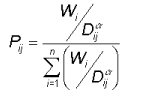

Where:
 - Pij = the probability of consumer j shopping at store i.
 - Wi = a measure of the attractiveness of each store or site i.
 - Dij = the distance from consumer j to store or site i.
 - a = an exponent applied to distance so the probability of distant sites is dampened. It usually ranges between 1.5 and 2.

### 1. System Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import requests
import json
import cartopy.crs as ccrs
import psycopg2
import sqlalchemy as db
from pyproj import Proj
from shapely.geometry import Point
import openrouteservice
from openrouteservice.directions import directions
from openrouteservice.isochrones import isochrones
import plotly.express as px
from openrouteservice import client

### 2. Data Preparation

In [2]:
adm = gpd.read_file('Batas Desa terbaru Maret 2020.shp')

### 3. Processing

#### 3.1. One Store

In [3]:
def ISO(lon,lat,id):
    api_key = 'xxxxx'  # Provide your personal API key
    ors = client.Client(key=api_key)

    location = {id: {'location': [lon, lat]}}

    # Request of isochrones with 15 minute on foot.
    params_iso = {'profile': 'driving-car',
                  'range': [900],  # 900/60 = 15 minutes
                  'attributes': ['total_pop']  
                  }
    for name, loc in location.items():
        params_iso['locations'] = [loc['location']]  
        loc['iso'] = ors.isochrones(**params_iso)  
    return location

In [4]:
def POINT(lon,lat,store_size,id):
    location = ISO(lon,lat,id)
    point = {
        "id" : [id],
        "lon": [location[id]['location'][0]],
        "lat": [location[id]['location'][1]],
        "store_size" : [store_size],
        "geometry" : [Point(location[id]['location'][0],location[id]['location'][1])]
    }
    point = gpd.GeoDataFrame(point,crs='epsg:4326')
    return point

In [5]:
def INTERSECT_ADM(lon,lat,id, gdf_admin):
    location = ISO(lon,lat,id)
    isochrone = gpd.GeoDataFrame.from_features(location[id]['iso'])
    admin = gpd.sjoin(gdf_admin, isochrone[['geometry']], predicate='intersects', how='inner').reset_index()
    admin['lon'] = pd.DataFrame(admin.centroid)[0].apply(lambda p: p.x)
    admin['lat'] = pd.DataFrame(admin.centroid)[0].apply(lambda p: p.y)
    return admin

In [6]:
def Huff_Processing(lon, lat, store_size,id, gdf_admin):
    process = pd.DataFrame()
    process2 = pd.DataFrame()
    point = POINT(lon,lat,store_size,id)
    admin = INTERSECT_ADM(lon,lat, gdf_admin)
    for i in point.id:
        list_distance = []
        poi = point[point['id'] == i]
        for j in range(len(admin)):
            coords = ((poi.lon[0],poi.lat[0]),(admin['lon'][j],admin['lat'][j]))
            client = openrouteservice.Client(key='xxxxx') # Specify your personal API key
            routes = directions(client, coords) 
            list_distance.append(routes['routes'][0]['summary']['distance'])
        admin['dist_'+i] = list_distance
        size = point.loc[point['id'] == i, 'store_size']
        admin['attract_'+i] = size.values/admin['dist_'+i]
        process['attract_'+i] = pd.DataFrame(admin['attract_'+i])
    admin['total_attract'] = process.sum(axis=1)
    for k in point.id:
        admin['probability_'+k] = admin['attract_'+k]/admin['total_attract']*100
        process2['probability_'+k] = pd.DataFrame(admin['probability_'+k])
    admin['mrkt_shr'] = process2.idxmax(axis=1)
    return admin

#### 3.2. Two Store

In [7]:
def Huff_model_2Point(lon1, lat1, store_size1, id1,lon2, lat2, store_size2, id2,gdf_adm):
    point1 = POINT(lon1,lat1,store_size1, id1)
    point2 = POINT(lon2,lat2,store_size2, id2)
    join =[point1, point2]
    point = pd.concat(join)
    iso1 = ISO(lon1,lat1,id1)
    iso2 = ISO(lon2,lat2,id2)
    isochrone1 = gpd.GeoDataFrame.from_features(iso1[id1]['iso'])
    isochrone2 = gpd.GeoDataFrame.from_features(iso2[id2]['iso'])
    admin1 = gpd.sjoin(gdf_adm, isochrone1[['geometry']], predicate='intersects', how='inner').reset_index()
    admin2 = gpd.sjoin(gdf_adm, isochrone2[['geometry']], predicate='intersects', how='inner').reset_index()
    
    x = pd.concat([admin1,admin2])
    admin = x.drop_duplicates(subset='OBJECTID', keep='first').reset_index()
    admin['lon'] = pd.DataFrame(admin.centroid)[0].apply(lambda p: p.x)
    admin['lat'] = pd.DataFrame(admin.centroid)[0].apply(lambda p: p.y)
    
    process = pd.DataFrame()
    process2 = pd.DataFrame()
    for i in point.id:
        list_distance = []
        list_failed = []
        poi = point[point['id'] == i]
        for j in range(len(admin)):
            coords = ((poi.lon[0],poi.lat[0]),(admin['lon'][j],admin['lat'][j]))
            client = openrouteservice.Client(key='xxxxx') # Specify your personal API key
            try:
                routes = directions(client, coords)
                y = routes['routes'][0]['summary']['distance']
            except:
                y = 0
            list_distance.append(y)
        admin['dist_'+i] = list_distance
        size = point.loc[point['id'] == i, 'store_size']
        admin['attract_'+i] = size.values/admin['dist_'+i]
        process['attract_'+i] = pd.DataFrame(admin['attract_'+i])
    admin['total_attract'] = process.sum(axis=1)
    for k in point.id:
        admin['probability_'+k] = admin['attract_'+k]/admin['total_attract']*100
        process2['probability_'+k] = pd.DataFrame(admin['probability_'+k])
    admin['mrkt_shr'] = process2.idxmax(axis=1)
    
    return admin, point

### 4. Visualization

In [8]:
lon1, lat1, store_size1, id1 = 107.62933, -6.93, 200, 'A'
lon2, lat2, store_size2, id2 = 107.63933, -6.87, 150, 'B'
gdf_adm = adm
data = Huff_model_2Point(lon1, lat1, store_size1, id1,lon2, lat2, store_size2, id2,gdf_adm)

C:\Users\Asani\AppData\Local\Temp\ipykernel_6864\3105612862.py:10: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  admin1 = gpd.sjoin(gdf_adm, isochrone1[['geometry']], predicate='intersects', how='inner').reset_index()
C:\Users\Asani\AppData\Local\Temp\ipykernel_6864\3105612862.py:11: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  admin2 = gpd.sjoin(gdf_adm, isochrone2[['geometry']], predicate='intersects', how='inner').reset_index()
C:\Users\Asani\AppData\Local\Temp\ipykernel_6864\3105612862.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a 

In [9]:
huff = data[0]
point = data[1]

In [10]:
color = ['Blues','Reds','Oranges']
id_data = point.id.tolist()
m = point.explore(style_kwds=dict(color='gray'),
                 tiles='cartodb dark_matter',
                 popup = False,
                 marker_kwds=dict(radius=7, fill=True),
                 color = 'yellow')

for i in range(len(id_data)):
    huff[huff['mrkt_shr']=='probability_'+point.id.tolist()[i]].explore(m=m, 
                                                                        column = 'probability_'+point.id.tolist()[i], 
                                                                        legend = False,
                                                                        scheme = 'Natural_Breaks',
                                                                        cmap = color[i],
                                                                        tooltip = ['dist_'+point.id.tolist()[0],
                                                                                   'dist_'+point.id.tolist()[1],
                                                                                   'probability_'+point.id.tolist()[0],
                                                                                   'probability_'+point.id.tolist()[1], 
                                                                                   'mrkt_shr'])
m

C:\Users\Asani\anaconda3\envs\geopan_env\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Asani\anaconda3\envs\geopan_env\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [11]:
m.save('huff_model.html')